In [4]:
# ================================
# 04 — PROFILES RANDOM FOREST
# ================================

import json
import gc
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Centralized config
from config import RAW_DATA_DIR, EXP_DIR_ROOT, SEED, TEST_RATIO, FPS_LIST

print(f"Raw data directory: {RAW_DATA_DIR}")
print(f"FPS list: {FPS_LIST}")

Raw data directory: R:\MUL\Courses\Applied ML\raman-mineral-classification\data\raw
FPS list: ['1fps', '30fps']


In [5]:
# ---------
# Cell 2: Setup directories
# ---------
EXP_DIR = EXP_DIR_ROOT / "profiles_random_forest"
EXP_DIR.mkdir(parents=True, exist_ok=True)

print(f"Experiment directory: {EXP_DIR}")

# Verify data exists
for fps in FPS_LIST:
    fps_files = list(RAW_DATA_DIR.glob(f"**/{fps}/*.csv"))
    fps_profiles = [f for f in fps_files if "profiles" in f.name.lower()]
    print(f"Found {len(fps_profiles)} profile files for {fps}")

Experiment directory: R:\MUL\Courses\Applied ML\raman-mineral-classification\experiments\profiles_random_forest
Found 14 profile files for 1fps
Found 15 profile files for 30fps



Processing: 1fps
Loading profiles for 1fps...
✓ Loaded 136456 samples, 2369 features
✓ Classes: ['Albit', 'Calcite', 'Dolomit', 'Feldspat', 'Quarz', 'Rhodocrosite', 'Tile']
Splitting data (10.0% test)...
✓ Train: 122810, Test: 13646
Standardizing features...
Training Random Forest (2369 features)...
Evaluating model...

📊 Results for 1fps:
✓ Accuracy: 1.0000

📄 Classification Report:
              precision    recall  f1-score   support

       Albit       1.00      1.00      1.00      1000
     Calcite       1.00      1.00      1.00      5645
     Dolomit       1.00      1.00      1.00      2001
    Feldspat       1.00      1.00      1.00      1000
       Quarz       1.00      1.00      1.00      1000
Rhodocrosite       1.00      1.00      1.00      2000
        Tile       1.00      1.00      1.00      1000

    accuracy                           1.00     13646
   macro avg       1.00      1.00      1.00     13646
weighted avg       1.00      1.00      1.00     13646



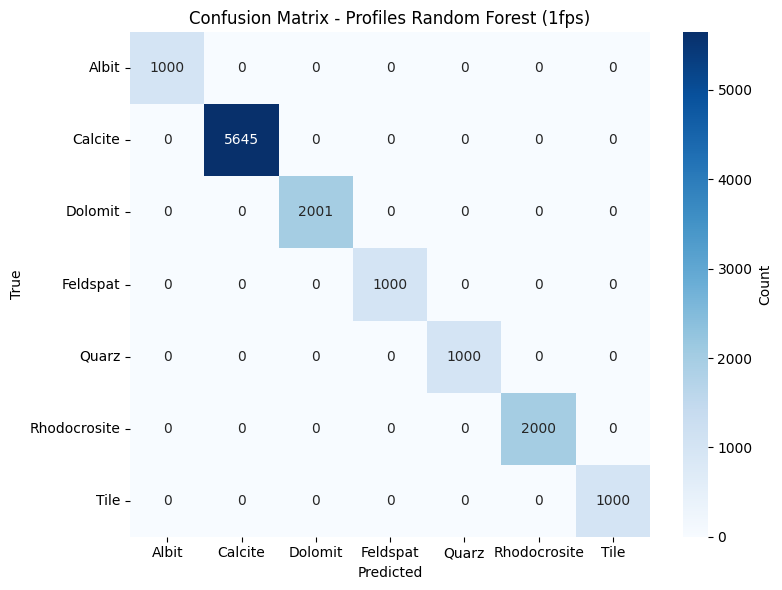

Saving model...
✓ Saved to R:\MUL\Courses\Applied ML\raman-mineral-classification\experiments\profiles_random_forest\1fps

Processing: 30fps
Loading profiles for 30fps...
✓ Loaded 149985 samples, 2446 features
✓ Classes: ['Albit', 'Calcite', 'Dolomit', 'Feldspat', 'Quarz', 'Rhodocrosite', 'Tile']
Splitting data (10.0% test)...
✓ Train: 134986, Test: 14999
Standardizing features...
Training Random Forest (2446 features)...
Evaluating model...

📊 Results for 30fps:
✓ Accuracy: 1.0000

📄 Classification Report:
              precision    recall  f1-score   support

       Albit       1.00      1.00      1.00      1000
     Calcite       1.00      1.00      1.00      5999
     Dolomit       1.00      1.00      1.00      2000
    Feldspat       1.00      1.00      1.00      1000
       Quarz       1.00      1.00      1.00      1000
Rhodocrosite       1.00      1.00      1.00      3000
        Tile       1.00      1.00      1.00      1000

    accuracy                           1.00     14999

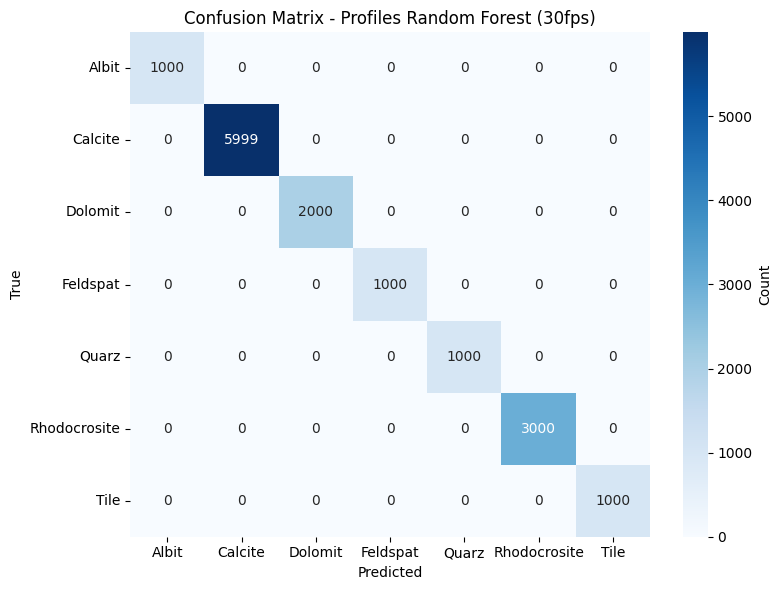

Saving model...
✓ Saved to R:\MUL\Courses\Applied ML\raman-mineral-classification\experiments\profiles_random_forest\30fps

✅ Training complete for all FPS levels

Summary:
1fps: Accuracy = 1.0000
30fps: Accuracy = 1.0000


In [6]:
# ---------
# Cell 3: Train Random Forest per FPS (memory-efficient)
# ---------

def load_profiles_for_fps(fps_label, data_dir=RAW_DATA_DIR):
    """Load all profile CSV files for a given FPS level."""
    df_list = []
    
    for f in data_dir.glob(f"**/{fps_label}/*.csv"):
        if "profiles" in f.name.lower():
            # Read as float32 to save memory
            df = pd.read_csv(f, dtype='float32')
            # Extract mineral name from folder
            mineral = f.parts[-3]
            df['mineral'] = mineral
            df_list.append(df)
    
    if not df_list:
        return None
    
    data = pd.concat(df_list, ignore_index=True)
    return data


# Train models for each FPS level
results_summary = {}

for fps_label in FPS_LIST:
    print(f"\n{'='*60}")
    print(f"Processing: {fps_label}")
    print(f"{'='*60}")
    
    # Load data
    print(f"Loading profiles for {fps_label}...")
    df = load_profiles_for_fps(fps_label)
    
    if df is None:
        print(f"⚠️  No profiles found for {fps_label}")
        continue
    
    print(f"✓ Loaded {len(df)} samples, {df.shape[1]-1} features")
    print(f"✓ Classes: {sorted(df['mineral'].unique())}")
    
    # Get feature columns (all except mineral)
    feature_cols = [col for col in df.columns if col != 'mineral']
    X = df[feature_cols].values.astype('float32')
    y = df['mineral'].values
    
    del df  # Free memory
    gc.collect()
    
    # Train-test split
    print(f"Splitting data ({TEST_RATIO*100}% test)...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_RATIO, random_state=SEED, stratify=y
    )
    
    print(f"✓ Train: {len(X_train)}, Test: {len(X_test)}")
    
    # Standardize features
    print(f"Standardizing features...")
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train).astype('float32')
    X_test = scaler.transform(X_test).astype('float32')
    
    # Train Random Forest
    print(f"Training Random Forest ({len(feature_cols)} features)...")
    rf = RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        max_features='sqrt',
        n_jobs=-1,
        random_state=SEED,
        verbose=0
    )
    rf.fit(X_train, y_train)
    
    # Evaluate
    print(f"Evaluating model...")
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"\n📊 Results for {fps_label}:")
    print(f"✓ Accuracy: {accuracy:.4f}")
    print(f"\n📄 Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    classes = sorted(np.unique(y_test))
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        xticklabels=classes,
        yticklabels=classes,
        cbar_kws={'label': 'Count'}
    )
    plt.title(f'Confusion Matrix - Profiles Random Forest ({fps_label})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()
    
    # Save model and artifacts
    print(f"Saving model...")
    exp_fps_dir = EXP_DIR / fps_label
    exp_fps_dir.mkdir(parents=True, exist_ok=True)
    
    joblib.dump(rf, exp_fps_dir / 'rf_model.pkl')
    joblib.dump(scaler, exp_fps_dir / 'scaler.pkl')
    
    # Save metrics
    metrics = {
        'accuracy': float(accuracy),
        'n_samples_train': len(X_train),
        'n_samples_test': len(X_test),
        'n_features': len(feature_cols),
        'n_estimators': 300,
        'classes': [str(c) for c in classes]
    }
    
    with open(exp_fps_dir / 'metrics.json', 'w') as f:
        json.dump(metrics, f, indent=2)
    
    # Store results
    results_summary[fps_label] = {
        'accuracy': accuracy,
        'n_test_samples': len(X_test),
        'classes': [str(c) for c in classes]
    }
    
    print(f"✓ Saved to {exp_fps_dir}")
    
    # Clean up
    del X_train, X_test, y_train, y_test, rf, scaler
    gc.collect()

print(f"\n{'='*60}")
print("✅ Training complete for all FPS levels")
print(f"{'='*60}")
print("\nSummary:")
for fps, results in results_summary.items():
    print(f"{fps}: Accuracy = {results['accuracy']:.4f}")